# Visualize CNN Weights and Activations

In [1]:
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import skimage.io
import skimage.transform
import skimage.filters
import keras
from keras.applications import vgg16
from keras import backend as K

# Allow graph embeding in notebook
%matplotlib inline

Using TensorFlow backend.


## Helper Functions

In [2]:
def tensor_summary(tensor):
    """Display shape, min, and max values of a tensor."""
    print("shape: {}  min: {}  max: {}".format(tensor.shape, tensor.min(), tensor.max()))

    
def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)


def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=9)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1


## Build VGG16 Convolutional Network

In [3]:
# Build a VGG16 Convolutional Network pre-trained on ImageNet
model = vgg16.VGG16(weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Test the Model on Random Images

/home/nivii/Desktop/python_environments/objectDet/local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


shape: (224, 224, 3)  min: 0.0633053221288513  max: 0.9949579831932773


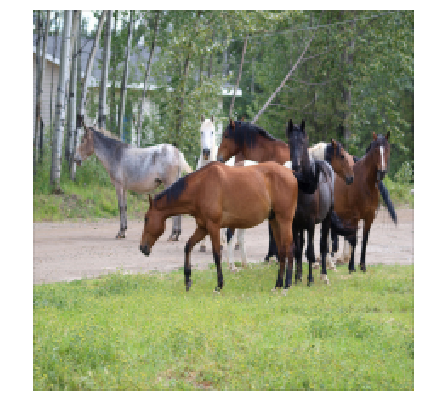

In [5]:
# Pick a random image from the Web.
# Make sure it's 224x224 image since VGG16 expects this size.
from skimage.transform import rescale, resize, downscale_local_mean
image = skimage.io.imread("coco2.jpg")#("http://lorempixel.com/224/224/animals/")
image = resize(image, (224, 224,3), anti_aliasing=True)
assert image.shape == (224, 224, 3), "Must be 224x224 RGB Image"
tensor_summary(image)
display_images([image], cols=2)

In [6]:
# Convert image to float
x = image.astype(np.float32)
# Make it a batch of one. The model expects a batch, not a single image
x = x[np.newaxis,...]
# Preprocess image. Convert RGB to BGR and subtract the ImageNet mean.
x = vgg16.preprocess_input(x)

In [7]:
# Classify the image
predictions = model.predict(x)
# We'll get a 1000 values. Print the first 10.
print(predictions[0][:10])

[0.00015007 0.00202565 0.00044089 0.00034905 0.0019899  0.00067106
 0.00031093 0.0002736  0.00019885 0.00045011]


In [8]:
# Find the largest confidence value. This corresponds to the label index.
label_index = np.argmax(predictions)
print("label index: ", label_index)
# Display the top 5 classes
vgg16.decode_predictions(predictions)

label index:  644


[[('n03729826', 'matchstick', 0.07625233),
  ('n01930112', 'nematode', 0.04903358),
  ('n03666591', 'lighter', 0.03046732),
  ('n03196217', 'digital_clock', 0.029418169),
  ('n04286575', 'spotlight', 0.023392778)]]

In [10]:
"""#from keras.applications.vgg16 import preprocess_input, decode_prediction
import keras.applications.imagenet_utils
# List of ImageNet classes. Print a subset of the 1000
# The previous call to decode_predictions() sets the value
# of CLASS_INDEX, so call that function first.
imagenet_classes = keras.applications.imagenet_utils.CLASS_INDEX
for i in range(10):
    print(i, imagenet_classes[str(i)][1])"""

'#from keras.applications.vgg16 import preprocess_input, decode_prediction\nimport keras.applications.imagenet_utils\n# List of ImageNet classes. Print a subset of the 1000\n# The previous call to decode_predictions() sets the value\n# of CLASS_INDEX, so call that function first.\nimagenet_classes = keras.applications.imagenet_utils.CLASS_INDEX\nfor i in range(10):\n    print(i, imagenet_classes[str(i)][1])'

## Heatmap

In [11]:
step = 56
heatmap_x = []
for row in range(0, image.shape[0], step):
    for col in range(0, image.shape[1], step):
        new_image = image.copy()
        # Add a square patch. Using a bright color here to make it easier to see.
        new_image[row:row+step, col:col+step, :] = [250,128,128]
        heatmap_x.append(new_image)
heatmap_x = np.stack(heatmap_x)
heatmap_x.shape

(16, 224, 224, 3)

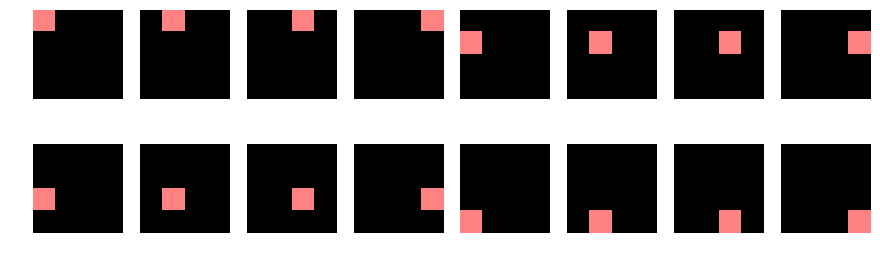

In [12]:
display_images(heatmap_x[:28], cols=8)

In [13]:
heatmap_y = model.predict(vgg16.preprocess_input(heatmap_x.astype(np.float32)))
tensor_summary(heatmap_y)

shape: (16, 1000)  min: 3.7435975173139013e-06  max: 0.14825484156608582


In [14]:
probs = heatmap_y[:, label_index]
tensor_summary(probs)

shape: (16,)  min: 0.04287176951766014  max: 0.08761797845363617


In [15]:
heatmap = (probs.max() - probs) / (probs.max()-probs.min())
heatmap = np.reshape(heatmap, (4, 4))
tensor_summary(heatmap)

shape: (4, 4)  min: 0.0  max: 1.0


shape: (4, 4)  min: 0.0  max: 1.0


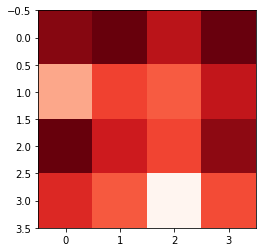

In [16]:
tensor_summary(heatmap)
_ = plt.imshow(heatmap, cmap=plt.cm.Reds)

/home/nivii/Desktop/python_environments/objectDet/local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/nivii/Desktop/python_environments/objectDet/local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


shape: (224, 224, 3)  min: 0.000310166719487282  max: 0.8086333768523357


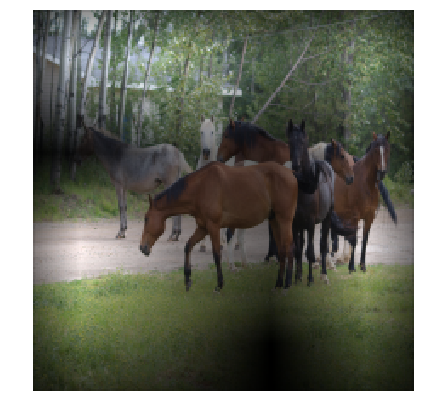

In [17]:
def apply_mask(image, mask):
    # Resize mask to match image size
    mask = skimage.transform.resize(normalize(mask), image.shape[:2])[:,:,np.newaxis].copy()
    # Apply mask to image
    image_heatmap = image * mask
    tensor_summary(image_heatmap)
    display_images([image_heatmap], cols=2)


# Apply mask to image
apply_mask(image, heatmap**2)

## Visualize the Weights

In [18]:
weights = model.get_layer("block1_conv1").get_weights()[0]
weights.shape, weights.min(), weights.max()

((3, 3, 3, 64), -0.67140007, 0.6085159)

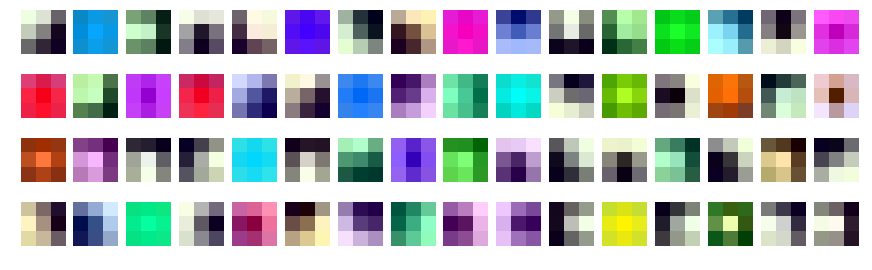

In [19]:
display_images([weights[:,:,::-1,i] for i in range(64)], cols=16, interpolation="none")

## Visualize Activations

In [20]:
def read_layer(model, x, layer_name):
    """Return the activation values for the specifid layer"""
    # Create Keras function to read the output of a specific layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])
    outputs = get_layer_output([x])[0]
    tensor_summary(outputs)
    return outputs[0]
    
def view_layer(model, x, layer_name, cols=5):
    outputs = read_layer(model, x, layer_name)
    display_images([outputs[:,:,i] for i in range(10)], cols=cols)

shape: (1, 224, 224, 64)  min: 0.0  max: 498.3380432128906


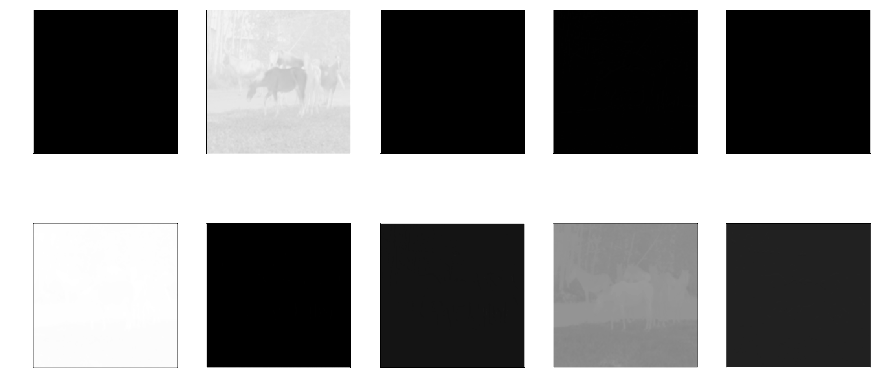

In [21]:
view_layer(model, x, "block1_conv1")

shape: (1, 224, 224, 64)  min: 0.0  max: 1149.0513916015625


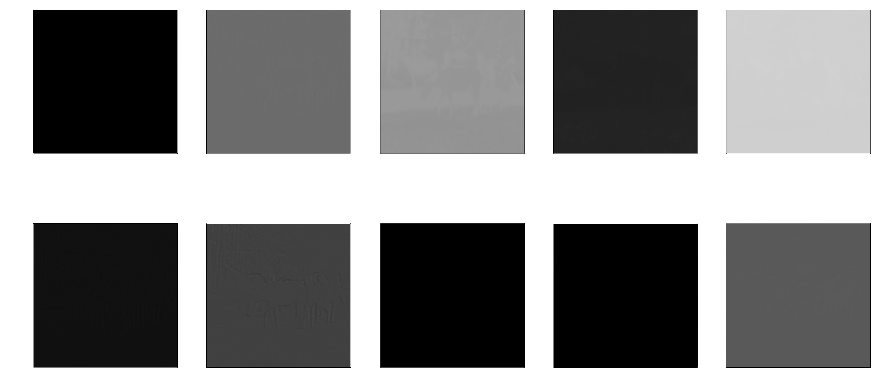

In [22]:
view_layer(model, x, "block1_conv2")

shape: (1, 112, 112, 128)  min: 0.0  max: 2007.108154296875


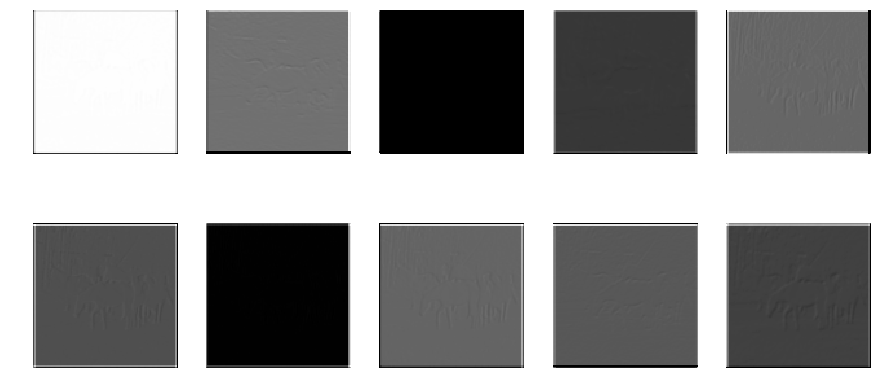

In [23]:
view_layer(model, x, "block2_conv1")

shape: (1, 56, 56, 256)  min: 0.0  max: 7377.3251953125


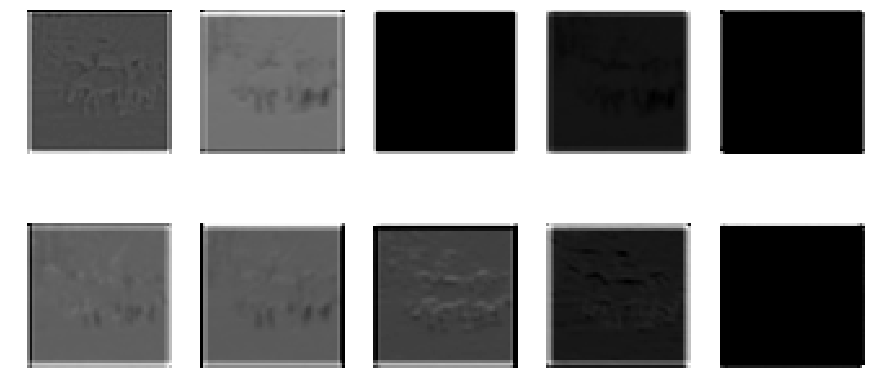

In [24]:
view_layer(model, x, "block3_conv1")

shape: (1, 28, 28, 512)  min: 0.0  max: 3994.209716796875


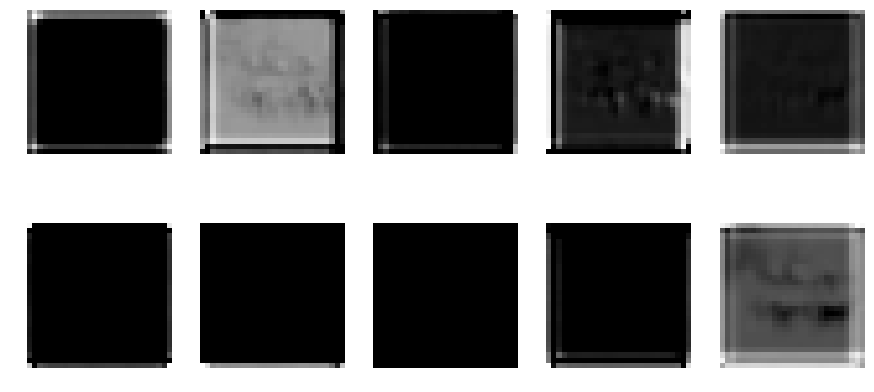

In [25]:
view_layer(model, x, "block4_conv1")

shape: (1, 14, 14, 512)  min: 0.0  max: 84.3017578125


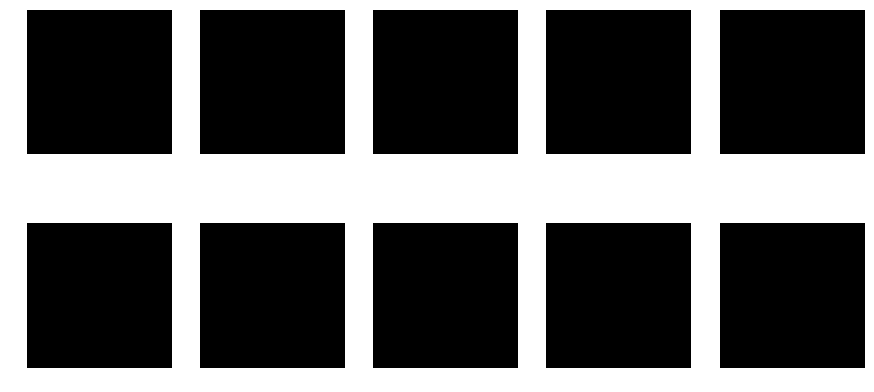

In [26]:
view_layer(model, x, "block5_conv3")

shape: (1, 14, 14, 512)  min: 0.0  max: 84.3017578125
shape: (224, 224, 3)  min: 0.0  max: 0.0


/home/nivii/Desktop/python_environments/objectDet/local/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/nivii/Desktop/python_environments/objectDet/local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


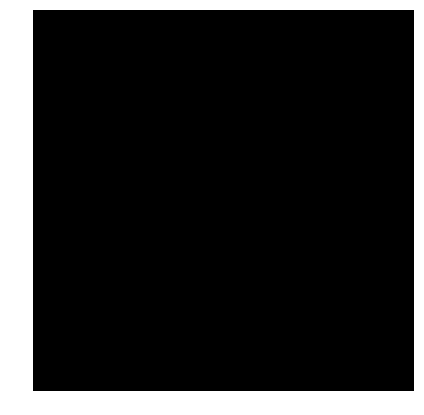

In [27]:
a = read_layer(model, x, "block5_conv3")
apply_mask(image, a[:,:, 0])

shape: (1, 1000)  min: 2.6507905204198323e-05  max: 0.07625232636928558


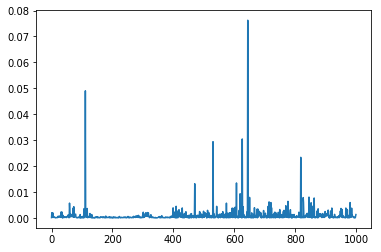

In [28]:
# The last layer is a 1D 1000-vector. Visualize as a bar chart.
a = read_layer(model, x, "predictions")
_ = plt.plot(a)

## Gradient Descent to Image Space

Or, gradient ascent, depending on which loss function you choose.

In [29]:
def build_backprop(model, loss):
    # Gradient of the input image with respect to the loss function
    gradients = K.gradients(loss, model.input)[0]
    # Normalize the gradients
    gradients /= (K.sqrt(K.mean(K.square(gradients))) + 1e-5)
    # Keras function to calculate the gradients and loss
    return K.function([model.input], [loss, gradients])

### Visualize the Gradients on the Input Image

shape: (1, 224, 224, 3)  min: -2.562528133392334  max: 2.7754123210906982


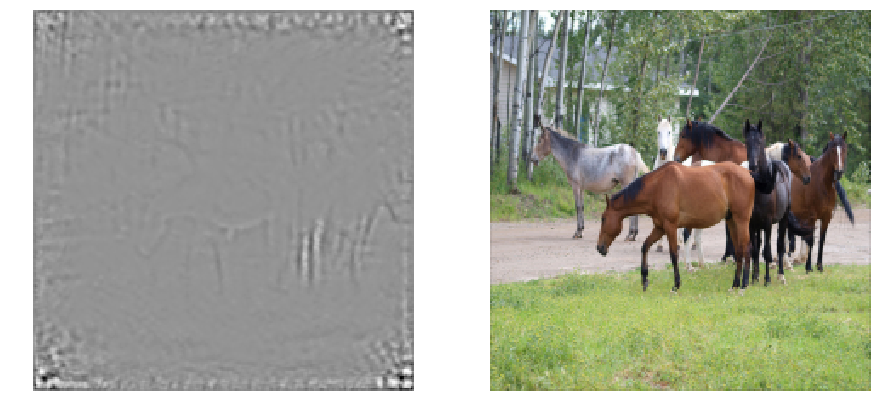

In [30]:
# Loss function that optimizes one class
loss_function = K.mean(model.get_layer("predictions").output[:,label_index])

# Backprop function
backprop = build_backprop(model, loss_function)

# Calculate gradients on the input image
loss, grads = backprop([x])
tensor_summary(grads)

# Visualize the gradients
grad_image = normalize(grads)
display_images([np.sum(grad_image[0], axis=2), image], cols=2)

## Generate an Image That Maximizes A Class 

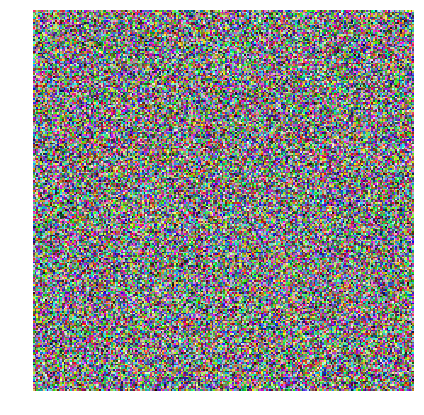

In [31]:
# Start with a random image
random_image = np.random.random((1, 224, 224, 3))
display_images(random_image, cols=2)

Loss: 0.0021659688
Loss: 0.014028425
Loss: 0.85556215
Loss: 0.99634874
Loss: 0.9980545
shape: (1, 224, 224, 3)  min: -5.546327385108236  max: 12.402469022292044


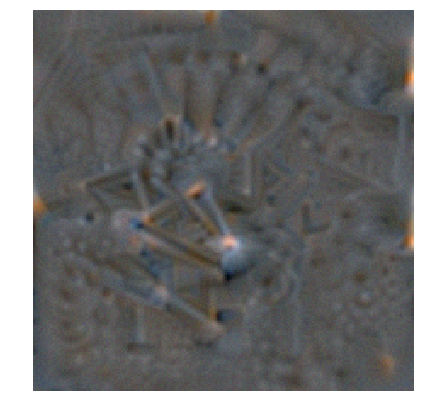

In [32]:
# Iteratively apply gradient ascent
for i in range(50):
    loss, grads = backprop([random_image])
    
    # Multiply gradients by the learning rate and add to the image
    # Optionally, apply a gaussian filter to the gradients to smooth
    # out the generated image. This gives better results.
    # The first line, which is commented out, is the native method
    # and the following line uses the filter. Try with both to
    # see the difference.
    #
    # random_image += grads * .1
    random_image += skimage.filters.gaussian(np.clip(grads, -1, 1), 2) 

    # Print loss value
    if i % 10 == 0:
        print('Loss:', loss)

tensor_summary(random_image)
display_images(random_image[...,::-1], cols=2)

In [33]:
# Classify the image
predictions = model.predict(random_image)
vgg16.decode_predictions(predictions)

[[('n03729826', 'matchstick', 0.9985998),
  ('n02948072', 'candle', 0.00014207725),
  ('n03794056', 'mousetrap', 0.000120181256),
  ('n03250847', 'drumstick', 0.00010883908),
  ('n03804744', 'nail', 7.924656e-05)]]

## Maximize Activations for a Hidden Filter

In [34]:
# Loss function that optimizes one class
loss_function = K.mean(model.get_layer("block3_conv2").output[:,:,:,2])

# Backprop function
backprop = build_backprop(model, loss_function)

# Start with a random image
random_image = np.random.random((1, 224, 224, 3)) 

Loss: 6.4567113
Loss: 61.753727
Loss: 108.038055
Loss: 154.74673
Loss: 202.60356
shape: (1, 224, 224, 3)  min: -28.889945927576683  max: 31.76744215021221


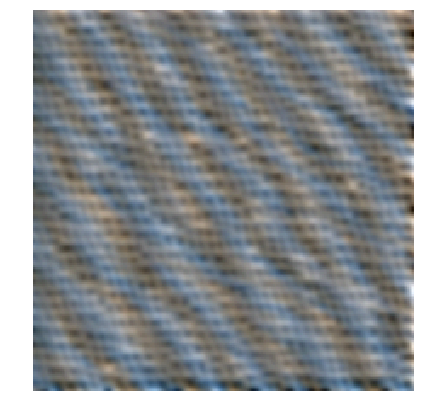

In [35]:
# Iteratively apply gradient ascent
for i in range(50):
    loss, grads = backprop([random_image])
    grads = np.nan_to_num(grads)  # In case gradients are NaN
    # Apply gradients with or without a gaussian filter
    # random_image += grads * .1
    random_image += skimage.filters.gaussian(np.clip(grads, -1, 1), 2) 
    if i % 10 == 0:
        print('Loss:', loss)

tensor_summary(random_image)
display_images(random_image[...,::-1], cols=2)